**Общая информация**

**Срок сдачи:** 21 октября 2019, 08:30 

**Штраф за опоздание:** по 0.5 балла за 24 часа задержки. Через 10 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0919, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Невыполнение PEP8 -0.5 баллов
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import ClassifierMixin
from sklearn.datasets import fetch_mldata, fetch_20newsgroups

from sklearn.neighbors.base import NeighborsBase, KNeighborsMixin, SupervisedIntegerMixin 
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from scipy.spatial.distance import cosine

from sklearn.neighbors import KDTree
import re

%load_ext pycodestyle_magic

##### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. Самостоятельно разберитесь, как считается score из KNeighborsClassifier и реализуйте аналог в своём классе. Score не должен уступать значению KNN из sklearn

In [37]:
#%%pycodestyle


class MyKNeighborsClassifier(NeighborsBase, KNeighborsMixin,
                             SupervisedIntegerMixin, ClassifierMixin):

    def __init__(self, n_neighbors, algorithm='brute',
                 weights='uniform', metric='minkowski', p=2,
                 manual_neighbors=False, manual__all_nearest_indices=[],
                 manual__all_nearest_dists=[]):
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.algorithm = algorithm
        self.metric = metric
        self.p = p
        self.manual_neighbors = manual_neighbors

    def fit(self, X, y,
            manual__all_nearest_indices=[], manual__all_nearest_dists=[]):
        self.X_fixed = np.array(X)
        self.y_fixed = np.array(y)
        self.classes_ = np.unique(self.y_fixed)

        if self.manual_neighbors:
            self.manual__all_nearest_indices = manual__all_nearest_indices
            self.manual__all_nearest_dists = manual__all_nearest_dists
        else:
            if self.metric == 'minkowski':
                self.X_fixed_reshaped = np.array(
                    [self.X_fixed[:, i] for i in range(self.X_fixed.shape[1])])

            if self.algorithm == 'kd_tree':
                self.tree = KDTree(self.X_fixed)

    def get_dists(self, x):
        x = np.array(x)
        if self.metric == 'minkowski':
            diff = self.X_fixed_reshaped - x.reshape(-1, 1)
            return (abs(diff)**self.p).sum(axis=0)**(1/self.p)
        if self.metric == 'cosine':
            res = np.array(
                list(map(lambda x_fixed: cosine(x_fixed, x), self.X_fixed)))
            return res

    # получаем упорядоченный массив n ближайших классов
    # и массив n расстояний от них до x для каждого x из X
    def get_nearest_neighbors(self, X):
        if self.manual_neighbors:
            return (self.manual__all_nearest_indices[:, :self.n_neighbors],
                    self.manual__all_nearest_dists[:, :self.n_neighbors])
        if self.algorithm == 'brute':
            all_indices = []
            all_dists = []
            for x in X:
                dists = self.get_dists(x)
                nearest_indices = np.argsort(dists)[:self.n_neighbors]
                nearest_dists = dists[nearest_indices]
                all_indices.append(nearest_indices)
                all_dists.append(nearest_dists)
            return np.array(all_indices), np.array(all_dists)

        if self.algorithm == 'kd_tree':
            all_dists, all_indices = self.tree.query(X, k=self.n_neighbors)
            return (np.array(all_indices)[:, :self.n_neighbors],
                    np.array(all_dists)[:, :self.n_neighbors])

    # получаем веса этих n классов
    def get_nearest_weights(self, nearest_dists):
        if self.weights == 'uniform':
            nearest_weights = np.ones(len(nearest_dists))/len(nearest_dists)

        return nearest_weights

    # получаем массив весов для всех классов выборки для каждого x из X
    def get_class_weights(self, X):
        all_nearest_indices, all_nearest_dists = self.get_nearest_neighbors(X)
        all_nearest_weights = np.array(list(map(self.get_nearest_weights,
                                                all_nearest_dists)))

        all_class_weights = []
        for i in range(len(all_nearest_weights)):
            nearest_classes = self.y_fixed[all_nearest_indices[i]]
            class_weights = np.array(
                [all_nearest_weights[i, nearest_classes == class_].sum()
                    for class_ in self.classes_])
            all_class_weights.append(class_weights)
        return all_class_weights

    def predict(self, X):
        all_class_weights = self.get_class_weights(X)
        return list(
            map(lambda class_weights: self.classes_[class_weights.argmax()],
                all_class_weights))

    def predict_proba(self, X):
        all_class_weights = self.get_class_weights(X)
        return list(
            map(lambda class_weights: class_weights/class_weights.sum(),
                all_class_weights))

    def score(self, X, y):
        difference = self.predict(X) - y
        difference[difference != 0] = 1
        return 1 - difference.mean()


In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 2 (0.5 балла)**

Давайте попробуем добиться скорости работы на fit, predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy

In [8]:
%time clf.fit(X_train, y_train)

Wall time: 2.11 ms


KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [9]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [10]:
%time clf.predict(X_test)

Wall time: 7 ms


array([1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 0, 2])

In [11]:
%time my_clf.predict(X_test)

Wall time: 8.36 ms


[1, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 2, 2, 0, 2]

In [24]:
%time clf.predict_proba(X_test)

Wall time: 4.35 ms


array([[0. , 1. , 0. ],
       [0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ]])

In [25]:
%time my_clf.predict_proba(X_test)

Wall time: 5.01 ms


[array([0., 1., 0.]),
 array([0. , 0.5, 0.5]),
 array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([0., 0., 1.]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([0., 0., 1.]),
 array([1., 0., 0.]),
 array([0., 0., 1.])]

###### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict и predict_proba сравнимой со sklearn для iris.
Для этого используем numpy. Score не должен уступать значению KNN из sklearn

In [26]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [27]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [28]:
%time clf.fit(X_train, y_train)

Wall time: 9.58 ms


KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

In [29]:
%time my_clf.fit(X_train, y_train)

Wall time: 4.56 ms


In [30]:
%time clf.predict(X_test)

Wall time: 10.2 ms


array([1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 1, 2, 0, 0, 0])

In [31]:
%time my_clf.predict(X_test)

Wall time: 6.59 ms


[1, 0, 1, 1, 1, 0, 2, 1, 2, 1, 1, 2, 0, 0, 0]

In [32]:
%time clf.predict_proba(X_test)

Wall time: 4.03 ms


array([[0. , 0.5, 0.5],
       [1. , 0. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ],
       [0. , 0. , 1. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [1. , 0. , 0. ]])

In [33]:
%time my_clf.predict_proba(X_test)

Wall time: 6.24 ms


[array([0. , 0.5, 0.5]),
 array([1., 0., 0.]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([1., 0., 0.]),
 array([0., 0., 1.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([0., 1., 0.]),
 array([0., 1., 0.]),
 array([0., 0., 1.]),
 array([1., 0., 0.]),
 array([1., 0., 0.]),
 array([1., 0., 0.])]

In [34]:
assert abs(my_clf.score(X_test, y_test) - clf.score(X_test,y_test))<0.005, "Score must be simillar"

**Задание 4 (2.5 балла)**

Рассмотрим новый датасет 20 newsgroups

In [35]:
newsgroups = fetch_20newsgroups(subset='train', remove=['headers','footers', 'quotes'])

In [36]:
data = newsgroups['data']
target = newsgroups['target']

Переведите во всех документах все буквы в нижний регистр и замените во всех документах символы, не
являющиеся буквами и цифрами, на пробелы. Далее разбейте текста по пробельным символам на токены(термы/слова). Удалите текста, содержащие только пробелы.

In [5]:
#%%pycodestyle


def transform_dataset(data, target):
    texts = [re.sub(r'\W', ' ', text.lower()) for text in data]
    tokenized_texts = []
    targets = []
    for i in range(len(texts)):
        if not texts[i].isspace() and texts[i] != '':
            tokenized_texts.append(re.split(' ', texts[i]))
            targets.append(target[i])

    return tokenized_texts, np.array(targets)


In [6]:
data_tok, targets = transform_dataset(data, target)

In [7]:
assert all(isinstance(row, (list, tuple)) for row in data_tok), "please convert each line into a list of tokens (strings)"
assert all(all(isinstance(tok, str) for tok in row) for row in data_tok), "please convert each line into a list of tokens (strings)"
is_latin = lambda tok: all('a' <= x.lower() <= 'z' for x in tok)
assert all(map(lambda l: not is_latin(l) or l.islower() , map(' '.join, data_tok))), "please make sure that you lowercase the data and drop spaced texts"

Преобразуйте датасет в разреженную матрицу scipy.sparse.csr_matrix, где значение x в позиции (i, j)
означает, что в документе i слово j встретилось x раз

In [8]:
from scipy.sparse import csr_matrix

In [9]:
#%%pycodestyle

word_position = {}
column_indices = []
values = []
indptr = [0]

for text in data_tok:
    for word in text:
        index = word_position.setdefault(word, len(word_position))
        column_indices.append(index)
        values.append(1)
    indptr.append(len(column_indices))

M = csr_matrix((values, column_indices, indptr))


In [10]:
M.shape

(11004, 101676)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [31]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=3)

In [32]:
for train_index, validation_index in kf.split(M):
    print("TRAIN:", train_index, "VALIDATION:", validation_index)

TRAIN: [ 3668  3669  3670 ... 11001 11002 11003] VALIDATION: [   0    1    2 ... 3665 3666 3667]
TRAIN: [    0     1     2 ... 11001 11002 11003] VALIDATION: [3668 3669 3670 ... 7333 7334 7335]
TRAIN: [   0    1    2 ... 7333 7334 7335] VALIDATION: [ 7336  7337  7338 ... 11001 11002 11003]


Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальный score в среднем на валидации на 3 фолдах).
Постройте график зависимости среднего score от количества соседей. Можно рассмотреть число соседей от 1 до 10.

убираем слова с общей частотой < 10 (не хватает ОЗУ)

In [11]:
word_freq = np.array(M.sum(axis=0))[0]

In [12]:
X = M.toarray()
X_reduced = X[:, word_freq>10]

In [56]:
#%%pycodestyle

score = np.zeros(11)

for train_index, validation_index in kf.split(M):
    my_knn = MyKNeighborsClassifier(n_neighbors=10, algorithm='kd_tree')
    my_knn.fit(X_reduced[train_index, :], targets[train_index])
    all_indices, all_dists = my_knn.get_nearest_neighbors(
        X_reduced[validation_index])
    print("neighbors done")
    for k in range(1, 11):
        my_knn = MyKNeighborsClassifier(
            n_neighbors=k, manual_neighbors=True)
        my_knn.fit([], targets[train_index], all_indices, all_dists)
        score[k] += my_knn.score(
            X_reduced[validation_index], targets[validation_index])

score /= 3
score


neighbors done
neighbors done
neighbors done


array([0.        , 0.13913123, 0.1240458 , 0.12459106, 0.12468193,
       0.12540894, 0.12586332, 0.12640858, 0.1278626 , 0.13022537,
       0.13095238])

In [66]:
print('maximal score: {0}, k = {1}'.format(score.max(), score.argmax()))

maximal score: 0.1391312250090876, k = 1


In [58]:
import pandas as pd
my_series = pd.Series(score[1:11])
my_series.index = range(1,11)

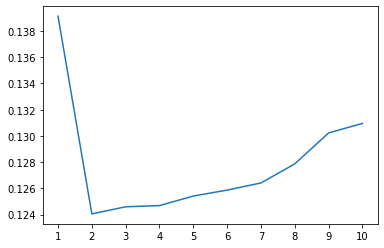

In [59]:
plt.plot(my_series)
plt.xticks(np.arange(1, 11, 1.0))
plt.show()

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf преобразование( sklearn.feature_extraction.text.TfidfTransformer)

Сравните модели, выберите лучшую.

In [15]:
#%%pycodestyle

score_cosine = np.zeros(11)

for train_index, validation_index in kf.split(M):
    my_knn = MyKNeighborsClassifier(
        n_neighbors=10, algorithm='brute', metric='cosine')
    my_knn.fit(X_reduced[train_index, :], targets[train_index])
    all_indices, all_dists = my_knn.get_nearest_neighbors(
        X_reduced[validation_index])
    print("neighbors done")
    for k in range(1, 11):
        my_knn = MyKNeighborsClassifier(n_neighbors=k, manual_neighbors=True)
        my_knn.fit([], targets[train_index], all_indices, all_dists)
        score_cosine[k] += my_knn.score(
            X_reduced[validation_index], targets[validation_index])

score_cosine /= 3
score_cosine


C:\Users\gaziz\Anaconda3\lib\site-packages\scipy\spatial\distance.py:702: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


neighbors done
neighbors done
neighbors done


array([0.        , 0.22355507, 0.21065067, 0.2086514 , 0.20683388,
       0.20383497, 0.20419847, 0.20438023, 0.20365322, 0.20401672,
       0.20556161])

In [16]:
print('maximal score: {0}, k = {1}'.format(score_cosine.max(), score_cosine.argmax()))

maximal score: 0.22355507088331517, k = 1


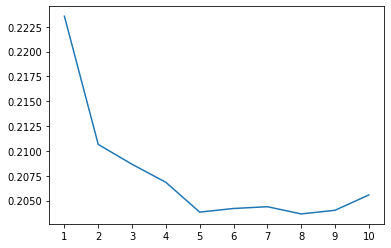

In [17]:
import pandas as pd
my_series = pd.Series(score_cosine[1:11])
my_series.index= range(1,11)
plt.plot(my_series)
plt.xticks(np.arange(1, 11, 1.0))
plt.show()

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer
trans = TfidfTransformer()
trans.fit(M)
M_tfidf = trans.transform(M)

In [14]:
X_reduced = M_tfidf[:, word_freq > 10].toarray()

In [15]:
#%%pycodestyle

score_tfidf = np.zeros(11)

for train_index, validation_index in kf.split(M_tfidf):
    my_knn = MyKNeighborsClassifier(n_neighbors=10, algorithm='kd_tree')
    my_knn.fit(X_reduced[train_index, :], targets[train_index])
    all_indices, all_dists = my_knn.get_nearest_neighbors(
        X_reduced[validation_index])
    print("neighbors done")
    for k in range(1, 11):
        my_knn = MyKNeighborsClassifier(n_neighbors=k, manual_neighbors=True)
        my_knn.fit([], targets[train_index], all_indices, all_dists)
        score_tfidf[k] += my_knn.score(
            X_reduced[validation_index], targets[validation_index])

score_tfidf /= 3
score_tfidf


neighbors done
neighbors done
neighbors done


array([0.        , 0.33033442, 0.34123955, 0.34778262, 0.34432933,
       0.34178481, 0.33796801, 0.33660487, 0.3346056 , 0.33651399,
       0.33324246])

In [20]:
print('maximal score: {0}, k = {1}'.format(score_tfidf.max(), score_tfidf.argmax()))

maximal score: 0.3477826245001818, k = 3


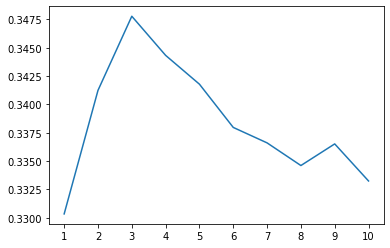

In [18]:
import pandas as pd
my_series = pd.Series(score_tfidf[1:11])
my_series.index= range(1,11)
plt.plot(my_series)
plt.xticks(np.arange(1, 11, 1.0))
plt.show()

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [15]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [16]:
data = newsgroups['data']
target = newsgroups['target']

In [17]:
test_data_tok, test_targets = transform_dataset(data, target)

In [19]:
#%%pycodestyle

column_indices = []
values = []
indptr = [0]

for text in test_data_tok:
    for word in text:
        if word in word_position:
            index = word_position[word]
            column_indices.append(index)
            values.append(1)
    indptr.append(len(column_indices))

M_test = csr_matrix((values, column_indices, indptr))


In [20]:
M_test.shape

(7309, 101676)

In [21]:
from sklearn.feature_extraction.text import TfidfTransformer
trans = TfidfTransformer()
trans.fit(M_test)
M_tfidf_test = trans.transform(M_test)

In [22]:
X_reduced_test = M_tfidf_test[:, word_freq > 10].toarray()

In [26]:
my_knn = MyKNeighborsClassifier(n_neighbors=3, algorithm='kd_tree')
my_knn.fit(X_reduced, targets)
my_knn.score(X_reduced_test, test_targets)

0.32193186482418934

Оценим качество(score) вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

Качество лучшей модели на тесте немного меньше, чем на кросс-валидации: 0.322 < 0.348.
Я считаю, это может быть связано с тем, что отношение размера теста к трейну на кросс валидации немного меньше, 
чем соответствующее отношение здесь:   

In [34]:
len(validation_index) / len(train_index)

0.5

In [35]:
len(X_reduced_test) / len(X_reduced)

0.6642130134496547

0.5 < 0.66

То есть в первом случае трейн покрыл большую часть теста, чем во втором.
Возможно из-за этого результаты предсказания там статистически лучше.